In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
df = pd.read_csv('training.csv')

In [3]:
df['MMRAcquisitionAuctionAveragePrice'].fillna(df['MMRAcquisitionAuctionAveragePrice'].median(), inplace = True)
df['MMRAcquisitionAuctionCleanPrice'].fillna(df['MMRAcquisitionAuctionCleanPrice'].median(), inplace = True)
df['MMRAcquisitionRetailAveragePrice'].fillna(df['MMRAcquisitionRetailAveragePrice'].median(), inplace = True)
df['MMRAcquisitonRetailCleanPrice'].fillna(df['MMRAcquisitonRetailCleanPrice'].median(), inplace = True)
df['MMRCurrentAuctionAveragePrice'].fillna(df['MMRCurrentAuctionAveragePrice'].median(), inplace = True)
df['MMRCurrentAuctionCleanPrice'].fillna(df['MMRCurrentAuctionCleanPrice'].median(), inplace = True)
df['MMRCurrentRetailAveragePrice'].fillna(df['MMRCurrentRetailAveragePrice'].median(), inplace = True)
df['MMRCurrentRetailCleanPrice'].fillna(df['MMRCurrentRetailCleanPrice'].median(), inplace = True)

In [4]:
df['MMR_factor'] = ( df['MMRAcquisitionAuctionAveragePrice'] + df['MMRAcquisitonRetailCleanPrice'] + df['MMRCurrentAuctionCleanPrice'] + df['MMRCurrentRetailAveragePrice']) / 4

In [5]:
df.isnull().sum() # Check if there are some numerical attributes with missing values

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1911
SubModel                                 7
Color                                    7
Transmission                             8
WheelTypeID                           2573
WheelType                             2577
VehOdo                                   0
Nationality                              4
Size                                     4
TopThreeAmericanName                     4
MMRAcquisitionAuctionAveragePrice        0
MMRAcquisitionAuctionCleanPrice          0
MMRAcquisitionRetailAveragePrice         0
MMRAcquisitonRetailCleanPrice            0
MMRCurrentAuctionAveragePrice            0
MMRCurrentA

In [6]:
df_new = df[['VehicleAge','VehOdo','MMR_factor','VehBCost','WarrantyCost']] #Create new dataframe the variables that we'll use in the clustering

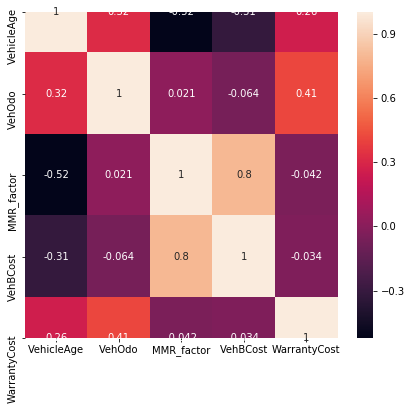

In [7]:
# check the correlation because we don't want clusters with two attributes highly correlated
corr = df_new.corr()
plt.subplots(figsize =(7, 6))
hm = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [8]:
Q1 =  df_new.quantile(0.25)
Q3 = df_new.quantile(0.75)
IQR = Q3 - Q1

In [9]:
df_in = df_new[(df_new > Q1-1.5*IQR ) & (df_new < Q3+1.5*IQR)]

In [10]:
df_in['VehBCost'].fillna(df['VehBCost'].median(), inplace = True)
df_in['WarrantyCost'].fillna(df['WarrantyCost'].median(), inplace = True)
df_in['VehicleAge'].fillna(df['VehicleAge'].median(), inplace = True)
df_in['MMR_factor'].fillna(df['MMR_factor'].median(), inplace = True)
df_in['VehOdo'].fillna(df['VehOdo'].median(), inplace = True)

In [11]:
df_in.isnull().sum()

VehicleAge      0
VehOdo          0
MMR_factor      0
VehBCost        0
WarrantyCost    0
dtype: int64

In [12]:
df1 = df_in[['VehBCost','VehOdo','WarrantyCost',]]

In [13]:
df1.head()

,VehBCost,VehOdo,WarrantyCost
0,6100.0,61184.0,533.0
1,4000.0,92383.0,1630.0
2,7500.0,45965.0,693.0
3,4725.0,80169.0,1633.0
4,5670.0,77372.0,1623.0


In [14]:
scaler = StandardScaler()
scaler.fit(df1.head().values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
df1.head().values

array([[ 6100., 61184.,   533.],
       [ 4000., 92383.,  1630.],
       [ 7500., 45965.,   693.],
       [ 4725., 80169.,  1633.],
       [ 5670., 77372.,  1623.]])

In [16]:
scaler.transform(df1.head().values)

array([[ 0.41777513, -0.63346427, -1.37838809],
       [-1.3333781 ,  1.29833365,  0.81495646],
       [ 1.58521061, -1.57580321, -1.05848369],
       [-0.72881329,  0.54206006,  0.82095467],
       [ 0.05920566,  0.36887378,  0.80096064]])

In [17]:
scaler.inverse_transform(scaler.transform(df1.head().values))

array([[ 6100., 61184.,   533.],
       [ 4000., 92383.,  1630.],
       [ 7500., 45965.,   693.],
       [ 4725., 80169.,  1633.],
       [ 5670., 77372.,  1623.]])

In [18]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df1.values)

In [19]:
X[:5]

array([[0.43211151, 0.3737992 , 0.03038083],
       [0.21528136, 0.75804227, 0.49978605],
       [0.57666495, 0.18636386, 0.09884467],
       [0.29013939, 0.60761614, 0.50106975],
       [0.38771296, 0.57316863, 0.49679076]])

In [20]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [21]:
Y = df1.sample(n=10000)

In [22]:
Y.describe()

,VehBCost,VehOdo,WarrantyCost
count,10000.000000,10000.000000,10000.000000
mean,6707.267279,71840.516300,1241.712600
std,1735.370584,14443.647766,496.331308
min,2000.000000,30868.000000,462.000000
25%,5405.000000,61981.250000,837.000000
50%,6700.000000,73541.000000,1155.000000
75%,7875.000000,82781.750000,1543.000000
max,11585.000000,110119.000000,2799.000000


In [23]:
df1.describe()

,VehBCost,VehOdo,WarrantyCost
count,58386.000000,58386.000000,58386.000000
mean,6714.939160,71689.046843,1240.662196
std,1720.064458,14256.818085,495.221352
min,1915.000000,30833.000000,462.000000
25%,5430.000000,62031.250000,837.000000
50%,6700.000000,73359.000000,1155.000000
75%,7895.000000,82425.000000,1543.000000
max,11600.000000,112029.000000,2799.000000


In [24]:
#TO START HIERACLICAL I HAVE DONE A SAMPLE TO IMPROVE RESULT IN REASONING OF TIME AND FACILTY TO UNDERSTAND RESULTS.
#I HAVE PRINTED THE DESCRIBE FUCTION IN ORDER TO COMPARE THE TWO GROUP. THEY LOOK LIKE SIMILAR SO I WOULD PROCEDE.


In [25]:
#I START WITH THE FIRD CLUSTER I WILL USE DIFFENRENT VARIABLES IN PRICNIPLE BUT BEFORE 
# EVALUATING ANY CLUSTER WITH DIFFERENT METRIC AND METHOD
#start with VehBCost	VehOdo	WarrantyCost and euclidian

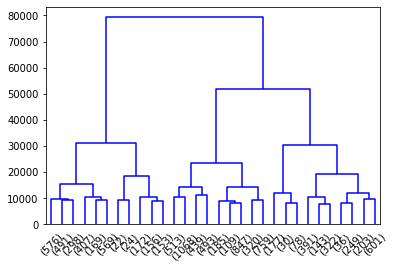

In [26]:
data_dist = pdist(Y, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

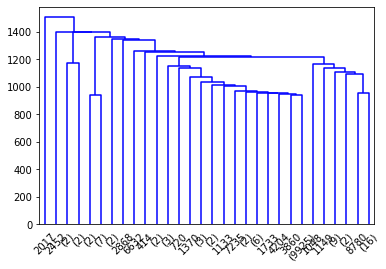

In [27]:
data_dist = pdist(Y, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

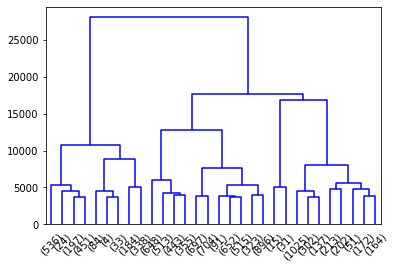

In [28]:
data_dist = pdist(Y, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

In [29]:
#same attributes with cityblock- manhattan distances

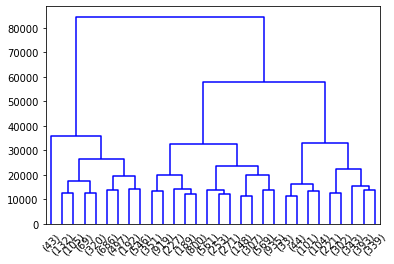

In [30]:
data_dist = pdist(Y, metric='cityblock')
data_link = linkage(data_dist, method='complete', metric='cityblock')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

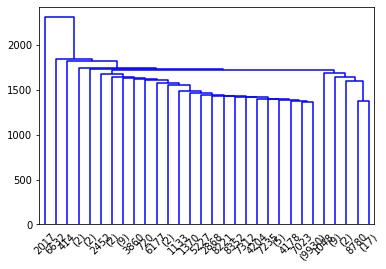

In [31]:
data_dist = pdist(Y, metric='cityblock')
data_link = linkage(data_dist, method='single', metric='cityblock')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

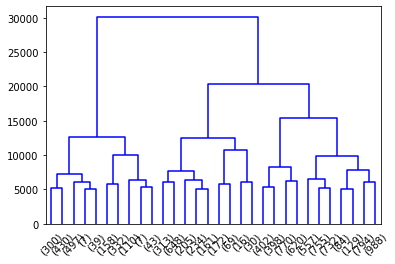

In [32]:
data_dist = pdist(Y, metric='cityblock')
data_link = linkage(data_dist, method='average', metric='cityblock')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

In [33]:
#now going further using other dataframe

In [34]:
#I decided to select the best you provided me using k.means and db scan

In [35]:
df2 = df_in[['VehBCost','VehicleAge']]

In [36]:
Y = df2.sample(n=10000)

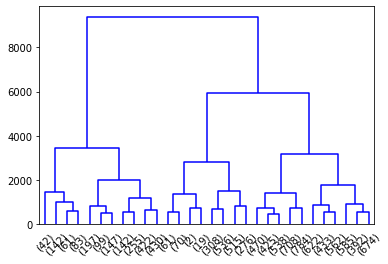

In [37]:
data_dist = pdist(Y, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

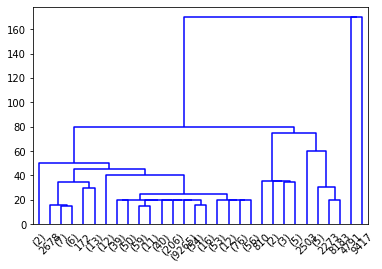

In [38]:
data_dist = pdist(Y, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

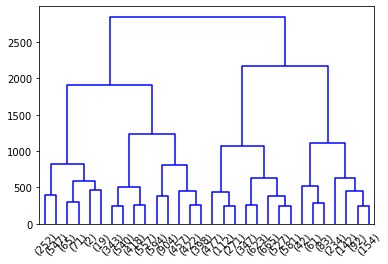

In [39]:
data_dist = pdist(Y, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

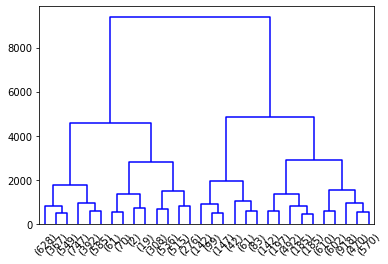

In [40]:
data_dist = pdist(Y, metric='cityblock')
data_link = linkage(data_dist, method='complete', metric='cityblock')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

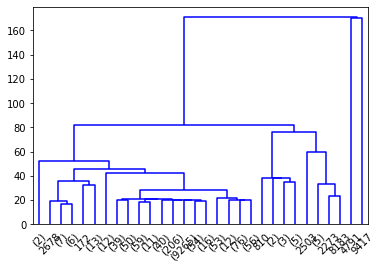

In [41]:
data_dist = pdist(Y, metric='cityblock')
data_link = linkage(data_dist, method='single', metric='cityblock')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

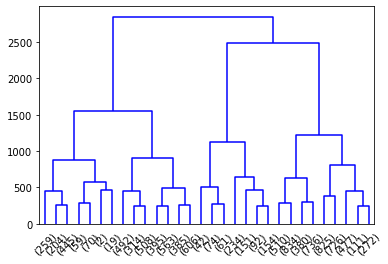

In [42]:
data_dist = pdist(Y, metric='cityblock')
data_link = linkage(data_dist, method='average', metric='cityblock')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

In [43]:
#keep going MMR_factor-vehicleage, this time i have normalized them

In [44]:
dfs = df_in.sample(n=10000)

In [45]:
dfh1 =dfs [['VehBCost','VehicleAge']]

In [46]:
X = MinMaxScaler().fit_transform(dfh1.values)

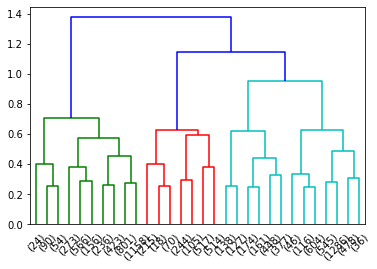

In [47]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

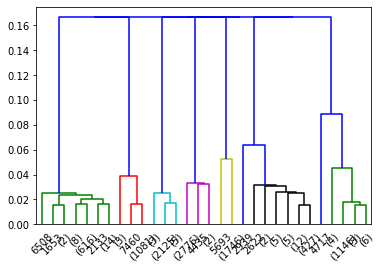

In [51]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.06, truncate_mode='lastp')

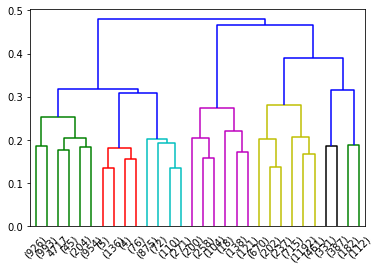

In [54]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.3, truncate_mode='lastp')

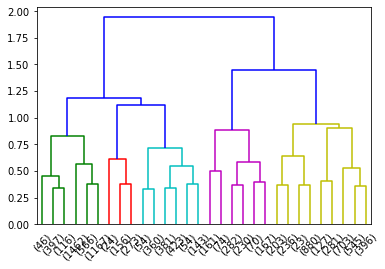

In [55]:
data_dist = pdist(X, metric='cityblock')
data_link = linkage(data_dist, method='complete', metric='cityblock')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

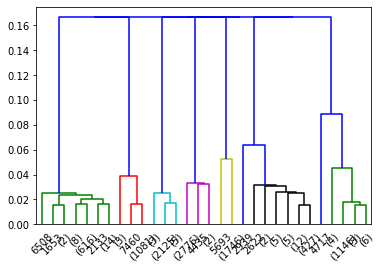

In [56]:
data_dist = pdist(X, metric='cityblock')
data_link = linkage(data_dist, method='single', metric='cityblock')
res = dendrogram(data_link, color_threshold=0.06, truncate_mode='lastp')

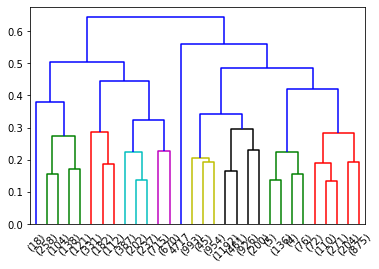

In [57]:
data_dist = pdist(X, metric='cityblock')
data_link = linkage(data_dist, method='average', metric='cityblock')
res = dendrogram(data_link, color_threshold=0.3, truncate_mode='lastp')